### Powerplants optimization

#### 1)Import Packages

In [1]:
import pypsa
#import pandapower as pp
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import warnings
import subprocess
from shapely.errors import ShapelyDeprecationWarning
import logging

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("pypsa.pf").setLevel(logging.WARNING)
plt.rc("figure", figsize=(10, 8))

#### 2)Create a network and set Snapshots

In [2]:
# Create a new PyPSA network
network = pypsa.Network()
network.set_snapshots(range(8760))  # Solve for a year 365*24

#### 3)Add Buses

In [3]:
# Define the buses (electricity demand)
network.add("Bus", "electricity_bus", carrier="electricity")

Index(['electricity_bus'], dtype='object')

In [4]:
network.buses

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
electricity_bus,1.0,,0.0,0.0,electricity,,1.0,0.0,inf,PQ,,


#### 4)Add generators

In [5]:
# Read excel file which contains Non renewable generators data
generators=pd.read_excel('data.xlsx',sheet_name='generators')

In [6]:
generators.head()

,generator,p_nom,p_nom_max,bus,p_nom_extendable,marginal_cost,lifetime,efficiency,start_up_cost,shut_down_cost,min_up_time,min_down_time,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
0,Coal,60,100,electricity_bus,True,35,25,0.3,50,NaN,4,3,0.54,0.75,NaN,NaN
1,Gas,40,120,electricity_bus,True,40,30,0.4,24,NaN,2,2,0.75,0.75,NaN,NaN


In [7]:
generators_sample=generators[['generator','p_nom']]

In [8]:
generators_sample

,generator,p_nom
0,Coal,60
1,Gas,40


In [9]:
network.madd(
    "Generator",
    generators.generator,
    bus='electricity_bus',
    carrier=list(generators.generator),
    p_nom=list(generators.p_nom),
    p_nom_max=list(generators.p_nom_max),  # MW
    p_nom_extendable=list(generators.p_nom_extendable),
    marginal_cost=list(generators.marginal_cost),
)
network.generators

C:\Users\onkar\AppData\Local\Temp\ipykernel_17924\810636836.py:1: DeprecatedWarning: madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.
  network.madd(


,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Coal,electricity_bus,PQ,,60.0,0.0,True,0.0,100.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Gas,electricity_bus,PQ,,40.0,0.0,True,0.0,120.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [10]:
# Read excel file which contains Renewable plants data
generators_renew=pd.read_excel('data.xlsx',sheet_name='generators_renew')
PV_timeseries=pd.read_excel('data.xlsx',sheet_name='PV_timeseries')
wind_timeseries=pd.read_excel('data.xlsx',sheet_name='wind_timeseries')

In [11]:
PV_timeseries.head()

,Unnamed: 0,solar_PV_kW,solar_PV_MW
0,2020-01-01 00:00:00,0.0,0.0
1,2020-01-01 01:00:00,0.0,0.0
2,2020-01-01 02:00:00,0.0,0.0
3,2020-01-01 03:00:00,0.0,0.0
4,2020-01-01 04:00:00,0.0,0.0


In [12]:
# Add generators Renewable
network.madd(
    "Generator",
    generators_renew.generator,
    bus='electricity_bus',
    carrier=list(generators_renew.generator),
    p_nom=list(generators_renew.p_nom),
    #p_max_pu=list(PV_timeseries.solar_PV_MW),
    p_nom_max=list(generators_renew.p_nom_max),
    capital_cost=list(generators_renew.capital_cost),
    marginal_cost=list(generators_renew.marginal_cost),
    efficiency=list(generators_renew.efficiency),
    p_nom_extendable=True,
    )
network.generators

C:\Users\onkar\AppData\Local\Temp\ipykernel_17924\1942226712.py:2: DeprecatedWarning: madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.
  network.madd(


,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Coal,electricity_bus,PQ,,60.0,0.0,True,0.0,100.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Gas,electricity_bus,PQ,,40.0,0.0,True,0.0,120.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
solarPV_rooftop,electricity_bus,PQ,,200.0,0.0,True,0.0,300.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
solarPV_utility,electricity_bus,PQ,,20.0,0.0,True,0.0,30.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
wind_offshore,electricity_bus,PQ,,60.0,0.0,True,0.0,100.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
wind_onshore,electricity_bus,PQ,,20.0,0.0,True,0.0,100.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [13]:
'''
In PyPSA (Python for Power System Analysis), network.generators_t is a DataFrame 
that stores time series data related to the generators in your power system network. 
Specifically, it contains information about how the generators operate over time, 
including their power output and other attributes.

'''
network.generators_t.p_max_pu["solar_pv_rooftop","solar_pv_utility"] = list(PV_timeseries.solar_PV_MW)
network.generators_t.p_max_pu["wind_offshore","wind_onshore"] = list(wind_timeseries.wind_power_MW)


In [14]:
network.generators_t.p_max_pu

Generator,"(solar_pv_rooftop, solar_pv_utility)","(wind_offshore, wind_onshore)"
snapshot,,
0,0.0,0.117738
1,0.0,0.174354
2,0.0,0.228422
3,0.0,0.266398
4,0.0,0.281166
...,...,...
8755,0.0,0.080681
8756,0.0,0.087623
8757,0.0,0.070398


#### 5)Add Carriers and CO2 emission constraints

In [15]:
co2_emissions=pd.read_excel('data.xlsx',sheet_name='co2_emissions')

In [16]:
# Add carriers with emissions associated with it
network.madd(
    "Carrier",
    network.generators.carrier.to_list(),
    nice_name=network.generators.carrier.to_list(),
    color=["dodgerblue", "yellowgreen", "gold", "magenta","indianred","aquablue"],
    co2_emissions=list(co2_emissions.co2_emissions)
)

C:\Users\onkar\AppData\Local\Temp\ipykernel_17924\1973941241.py:2: DeprecatedWarning: madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.
  network.madd(


Index(['Coal', 'Gas', 'solarPV_rooftop', 'solarPV_utility', 'wind_offshore',
       'wind_onshore'],
      dtype='object')

In [17]:
network.add(
    "GlobalConstraint",
    "emission_limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=5000, #Maximum limit of emissions in a year tonnes/MWh
)

Index(['emission_limit'], dtype='object')

#### 6)Add demand

In [18]:
# Read demand data from Excel file
demand_el=pd.read_excel('data.xlsx',sheet_name='load')
demand_el.load_MW_2020.head()

0    18
1    17
2    16
3    16
4    20
Name: load_MW_2020, dtype: int64

In [19]:
demand_el.load_MW_2020.sum()

336175

In [20]:
# Add demand time series
network.add(
    "Load",
    "demand",
    bus="electricity_bus",
    p_set=demand_el.load_MW_2020,
)

Index(['demand'], dtype='object')

<Axes: xlabel='snapshot', ylabel='MW'>

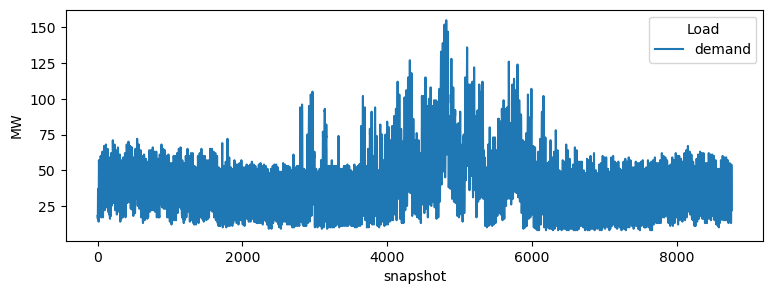

In [21]:
network.loads_t.p_set.plot(figsize=(9,3), ylabel="MW")

#### 7)Solve the Network

In [22]:
# Optimize the network to minimize the total cost
network.optimize(solver_name="highs")

Index([('solar_pv_rooftop', 'solar_pv_utility'), ('wind_offshore', 'wind_onshore')], dtype='object', name='Generator')
Index(['electricity_bus'], dtype='object', name='Bus')
Index([('solar_pv_rooftop', 'solar_pv_utility'), ('wind_offshore', 'wind_onshore')], dtype='object', name='Generator')
Index(['electricity_bus'], dtype='object', name='Bus')
c:\Users\onkar\.conda\envs\pypsa\Lib\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 10.67it/s]
INFO:linopy.io: Writing time: 2.73s
INFO:linopy.solvers:Log file at C:\Users\onkar\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
S

('ok', 'optimal')

#### 8)Results Visualization

In [23]:
# Print the results
print(f"Total Optimized Cost of Electricity Generation: {network.objective} €")
solution=network.generators_t.p
solution.to_csv("solution.csv")
solution.head(5)

Total Optimized Cost of Electricity Generation: -193333553.65474328 €


Generator,Coal,Gas,solarPV_rooftop,solarPV_utility,wind_offshore,wind_onshore
snapshot,,,,,,
0,-0.0,-0.0,18.0,-0.0,-0.0,-0.0
1,-0.0,-0.0,17.0,-0.0,-0.0,-0.0
2,-0.0,-0.0,-0.0,16.0,-0.0,-0.0
3,-0.0,-0.0,-0.0,16.0,-0.0,-0.0
4,-0.0,-0.0,20.0,-0.0,-0.0,-0.0


<Axes: xlabel='snapshot', ylabel='Generation MW'>

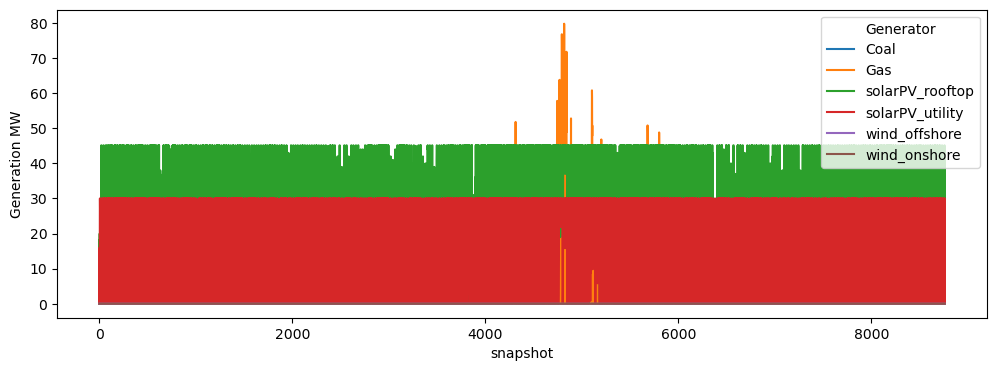

In [24]:
network.generators_t.p.plot(figsize=(12,4), ylabel="Generation MW")

In [25]:
solution['Coal'].idxmax()

0

In [26]:
# Individual emissions
emissions_ind = (network.generators_t.p* network.generators.carrier.map(network.carriers.co2_emissions))

# Total emissions
print(f"Total Emissions: {emissions_ind.sum()} tons")
print(f"Total Emissions: {emissions_ind.sum().sum()} tons")

Total Emissions: Generator
Coal                  0.0
Gas                5000.0
solarPV_rooftop       0.0
solarPV_utility       0.0
wind_offshore         0.0
wind_onshore          0.0
dtype: float64 tons
Total Emissions: 5000.000000000119 tons


In [27]:
network.generators_t.p.sum()

Generator
Coal                    0.000000
Gas                 12500.000000
solarPV_rooftop    189665.796267
solarPV_utility    134009.203733
wind_offshore           0.000000
wind_onshore            0.000000
dtype: float64

<Axes: xlabel='Generator', ylabel='Total generation MW'>

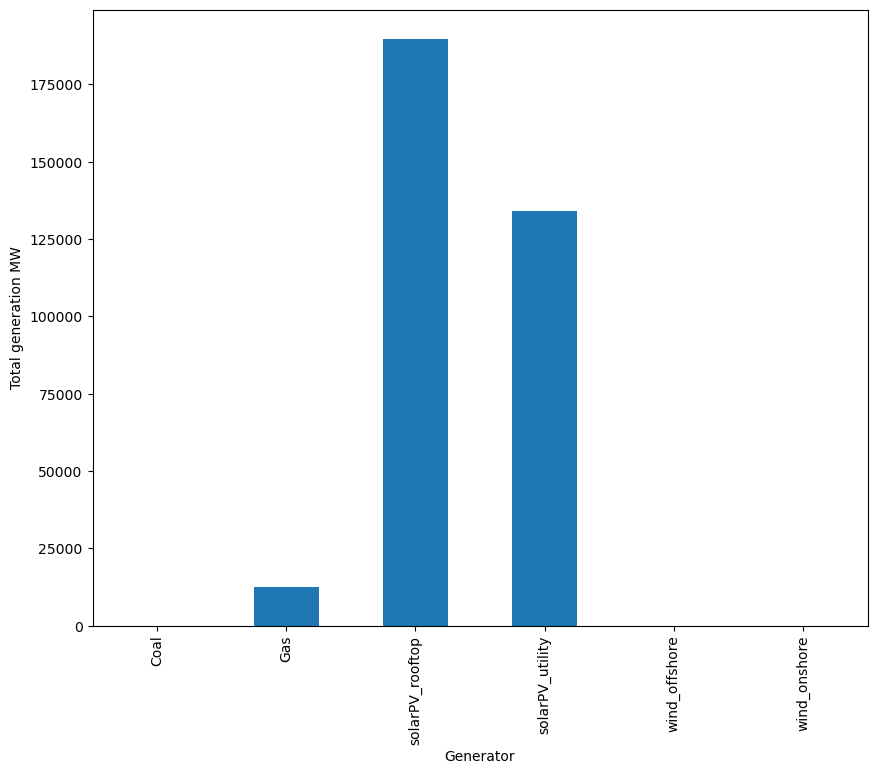

In [28]:
network.generators_t.p.sum().plot.bar(ylabel="Total generation MW")